### Team members: Chhavi Sharma, Prahasan Gadugu, Supriya Ayalur Balasubramanian

#### Mount google drive


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Import the required libraries

In [0]:
import h5py
import os
import glob
import numpy as np
import cv2
import random
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import Callback

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K

from keras.layers.core import Lambda, Activation
from keras.layers.merge import Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

#### Defining the variables


In [0]:
path = "/content/drive/My Drive/Deep Learning Project/Data/"
leftImg8bitpath = path + "leftImg8bit/"
gtFinePath = path + "gtFine/"

# Below are the 4 classes that is to be segmented
labels = ['background', 'human', 'vehicles', 'road']
num_classes = len(labels)

input_shape = (256, 512, 3)
learn_rate = 3e-4 
learn_rate_decay = 5e-4 
vgg_path = path + "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
model = VGG16(weights='imagenet', include_top=False)

#### Data Preprocessing: 
Read the folder stucture of the Cityscapes dataset and generate a .h5py data file

In [0]:
# Reads folder structure for the cityscape dataset.
def cityscapes_data_read(data_path):
  path_X = []
  path_Y = []
  imgpath = os.path.join(leftImg8bitpath, data_path)
  gtpath = os.path.join(gtFinePath, data_path)

  # Ref: https://stackoverflow.com/questions/10989005/do-i-understand-os-walk-right
  for (path, dirname, files) in os.walk(imgpath):
    for filename in files:
      path_X.append(os.path.join(path, filename))

  # Path of the ground truth files.
  idx = len(imgpath)
  for x in path_X:
    path_Y.append(gtpath + x[idx:-15] + 'gtFine_labelIds.png')
  return path_X, path_Y

# Ref: http://docs.h5py.org/en/stable/high/dataset.html#creating-datasets
# Generate data into a h5 group and write data
def generate_data_h5file(h5py_file, mode, x_paths, y_paths):
  data_len = len(x_paths)

  # h5py special data type for image.
  uint8_dtype = h5py.special_dtype(vlen=np.dtype('uint8'))

  # Make group and data set.
  group = h5py_file.create_group(mode)
  x_dataset = group.create_dataset('x', shape=(data_len, ), dtype=uint8_dtype)
  y_dataset = group.create_dataset('y', shape=(data_len, ), dtype=uint8_dtype)

  for i in range(data_len):
    x_image = cv2.imread(x_paths[i])
    x_image = cv2.resize(x_image, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)
    x_image = cv2.cvtColor(x_image, cv2.COLOR_BGR2RGB)
    x_dataset[i] = x_image.flatten()

    y_image = cv2.imread(y_paths[i])
    y_image = cv2.resize(y_image, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
    y_image = y_image[:, :, 0]
    y_dataset[i] = y_image.flatten()


# Generating h5 file
def write_to_h5file():
  x_train_paths, y_train_paths = cityscapes_data_read('train')
  x_val_paths, y_val_paths = cityscapes_data_read('val')
  x_test_paths, y_test_paths = cityscapes_data_read('test')

  # Make h5py file with write option.
  h5py_file = h5py.File(os.path.join(path, 'cityscapes.h5'), 'w')

  # Write data
  print('Write data')
  print('Train')
  generate_data_h5file(h5py_file, 'train', x_train_paths, y_train_paths)
  print('Validation')
  generate_data_h5file(h5py_file, 'val', x_val_paths, y_val_paths)
  print('Test')
  generate_data_h5file(h5py_file, 'test', x_test_paths, y_test_paths)
  print('Finish')

write_to_h5file()

Write data
Train
Validation
Test
Finish


#### Visualize the prediction on the test image

In [0]:
def visualize_predicted_image(orig_img, pred_img):
  original_image = np.squeeze(orig_img).astype(np.uint8)
  new_image = np.copy(original_image)
  prediction = np.squeeze(pred_img)
  argmax_idx = np.argmax(prediction, axis=2)

  # Background is yellow [255,255,0]
  new_image[argmax_idx[:,:]==0, :] = [255,255,0]
  
  # Human is Blue [0,0,255]
  new_image[argmax_idx[:,:]==1, :] = [0,0,255]
  
  # Vehicles is Red [255,0,0]
  new_image[argmax_idx[:,:]==2, :] = [255,0,0] 
  
  # Road is green [0,255,0]
  new_image[argmax_idx[:,:]==3, :] = [0,255,0]

  orig_image_rgba = Image.fromarray(original_image, mode='RGB').convert('RGBA')
  new_image_rgba = Image.fromarray(new_image, mode='RGB').convert('RGBA')
  new_image = Image.blend(orig_image_rgba, new_image_rgba, alpha=0.5)

  plt.imshow(new_image, interpolation='nearest')
  plt.show()

#### Read test image file to segment the image into the defined classes and visualise the predicted image

In [0]:
# predict on test image and visualize the predicted image
def plot(test_img):
  testimg = cv2.imread(test_img)
  testimg = cv2.resize(testimg,(512, 256),3)
  testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
  plt.imshow(testimg)
  plt.show()
  testimg = np.expand_dims(testimg, 0)
  testimg = testimg / 127.5 - 1  #Normalize the image

  pred = model.predict(testimg)
  visualize_predicted_image(testimg, pred)

#### Functions to calculate the metrics - Dice Coefficient and Intersection over Union (IoU)

In [0]:
# Calculate Metrics - Dice coefficient and IOU 
def dice(y_true, y_pred, smooth=1.):
  intersection = K.sum(y_true * y_pred)
  sum_y = K.sum(y_true) + K.sum(y_pred)
  union = sum_y - intersection
  numerator = 2. * intersection + smooth
  denominator = sum_y + smooth
  dice = numerator/denominator  
  return dice

def iou(y_true, y_pred, smooth=1.):
  intersection = K.sum(y_true * y_pred)
  sum_y = K.sum(y_true) + K.sum(y_pred)
  union = sum_y - intersection
  numerator = intersection + smooth
  denominator = union + smooth
  iou = numerator/denominator
  return iou

#### Image pre-processing and generate data

In [0]:
from keras.preprocessing.image import ImageDataGenerator

def fetch_files(imgs_dir, gt_dir):
  sub_dir = os.listdir(imgs_dir)
  gt = []
  imgs = []
  for folder in sub_dir:
    new_gt_path = os.path.join(gt_dir, folder)
    new_imgs_path = os.path.join(imgs_dir, folder)
    gt += glob.glob(os.path.join(new_gt_path, "*labelIds.png"))
    imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
  imgs.sort()
  gt.sort()
  return imgs, gt


def image_preprocessing(imagefile):
  saturation = random.uniform(0.9, 1.1)
  value = random.uniform(0.9, 1.1)

  temp_image = cv2.cvtColor(imagefile, cv2.COLOR_RGB2HSV)
  temp = np.ones_like(imagefile[:, :, 1]) * 255
  temp_image[:, :, 1] = np.where(temp_image[:, :, 1] * saturation > 255, temp, temp_image[:, :, 1] * saturation)
  temp_image[:, :, 2] = np.where(temp_image[:, :, 2] * value > 255, temp, temp_image[:, :, 2] * value)
  imagefile = cv2.cvtColor(temp_image, cv2.COLOR_HSV2RGB)

  return imagefile / 127.5 - 1


def generate_data(datapath, batchsize, runtype):
  city_data = h5py.File(datapath, 'r')
  x_imgs = city_data.get('/' + runtype + '/x')
  y_imgs = city_data.get('/' + runtype + '/y')

  if runtype == 'train' or runtype == 'val':
    x_args = dict(preprocessing_function=image_preprocessing, 
                  shear_range=0.1,
                  zoom_range=0.1,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  fill_mode='constant',
                  horizontal_flip=True)

    y_args = dict(shear_range=0.1,
                  zoom_range=0.1,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  fill_mode='constant',
                  horizontal_flip=True)

  elif runtype == 'test':
    x_args = dict(preprocessing_function=image_preprocessing)
    y_args = dict()

  xdata = ImageDataGenerator(**x_args)
  ydata = ImageDataGenerator(**y_args)

  
  data_shape = x_imgs.shape[0]
  shf_idx = list(range(data_shape))

  ximg_list = []
  yimg_list = []
  while True:
    random.shuffle(shf_idx)
    for i in range(data_shape):
      idx = shf_idx[i]
      ximg_list.append(x_imgs[idx].reshape((256, 512, 3)))
      yimg_list.append(y_imgs[idx].reshape((256, 512, 1)))

      if len(ximg_list) == batchsize:
        _ = np.zeros(batchsize)
        seed = random.randrange(1, 1000)
        x_tmp_gen = xdata.flow(np.array(ximg_list), _, batch_size=batchsize, seed=seed)
        y_tmp_gen = ydata.flow(np.array(yimg_list), _, batch_size=batchsize, seed=seed)
        x_result, _ = next(x_tmp_gen)
        y_result, _ = next(y_tmp_gen)

        # One Hot Encoding
        y_result = np.squeeze(y_result, axis=3)
        y_pred_map = np.zeros((batchsize, 256, 512, 4))
        
        # pedestrians [person, rider]
        human = np.logical_or(y_result == 24, y_result == 25)

        # vehicles [car, truck, bus, caravan, trailer, train, motorcycle, license plate]
        vehicles = np.logical_or.reduce((y_result == 26, y_result == 27, y_result == 28, 
                                         y_result == 29, y_result == 30, y_result == 31, 
                                         y_result == 32, y_result == 33, y_result == -1))
        
        # Road
        road = (y_result == 7)

        #Background (everything else other than the above three)
        background = np.logical_not(np.logical_or.reduce((road, human, vehicles)))

        y_pred_map[:, :, :, 0] = np.where(background, 1, 0)
        y_pred_map[:, :, :, 1] = np.where(human, 1, 0)
        y_pred_map[:, :, :, 2] = np.where(vehicles, 1, 0)
        y_pred_map[:, :, :, 3] = np.where(road, 1, 0)

        yield x_result, y_pred_map

        ximg_list.clear()
        yimg_list.clear()

#### U-Net Computational Graph

In [0]:
unet_input_image = Input(input_shape)

#UNET Layer snippet 1
conv_2D_Layer_11 = Conv2D(64, (3, 3), padding='same', name='conv_2D_Layer_1')(unet_input_image)
batch_norm_11 = BatchNormalization()(conv_2D_Layer_11)
activation_relu_11 = Activation('relu')(batch_norm_11)

conv_2D_Layer_12 = Conv2D(64, (3, 3), padding='same', name='conv_2D_Layer_2')(activation_relu_11)
batch_norm_12 = BatchNormalization()(conv_2D_Layer_12)
activation_relu_12 = Activation('relu')(batch_norm_12)

output_pool_1 = MaxPooling2D()(activation_relu_12)

#UNET Layer snippet 2
conv_2D_Layer_21 = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(output_pool_1)
batch_norm_21 = BatchNormalization()(conv_2D_Layer_21)
activation_relu_21 = Activation('relu')(batch_norm_21)

conv_2D_Layer_22 = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(activation_relu_21)
batch_norm_22 = BatchNormalization()(conv_2D_Layer_22)
activation_relu_22 = Activation('relu')(batch_norm_22)

output_pool_2 = MaxPooling2D()(activation_relu_22)

#UNET Layer snippet 3
conv_2D_Layer_31 = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(output_pool_2)
batch_norm_31 = BatchNormalization()(conv_2D_Layer_31)
activation_relu_31 = Activation('relu')(batch_norm_31)

conv_2D_Layer_32 = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(activation_relu_31)
batch_norm_32 = BatchNormalization()(conv_2D_Layer_32)
activation_relu_32 = Activation('relu')(batch_norm_32)

conv_2D_Layer_33 = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(activation_relu_32)
batch_norm_33 = BatchNormalization()(conv_2D_Layer_33)
activation_relu_33 = Activation('relu')(batch_norm_33)

output_pool_3 = MaxPooling2D()(activation_relu_33)

#UNET Layer snippet 4
conv_2D_Layer_41 = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(output_pool_3)
batch_norm_41 = BatchNormalization()(conv_2D_Layer_41)
activation_relu_41 = Activation('relu')(batch_norm_41)

conv_2D_Layer_42 = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(activation_relu_41)
batch_norm_42 = BatchNormalization()(conv_2D_Layer_42)
activation_relu_42 = Activation('relu')(batch_norm_42)

conv_2D_Layer_42 = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(activation_relu_42)
batch_norm_42 = BatchNormalization()(conv_2D_Layer_42)
activation_relu_42 = Activation('relu')(batch_norm_42)

output_pool_4 = MaxPooling2D()(activation_relu_42)

#UNET Layer snippet 5
conv_2D_Layer_51 = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(output_pool_4)
batch_norm_51 = BatchNormalization()(conv_2D_Layer_51)
activation_relu_51 = Activation('relu')(batch_norm_51)

conv_2D_Layer_52 = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(activation_relu_51)
batch_norm_52 = BatchNormalization()(conv_2D_Layer_52)
activation_relu_52 = Activation('relu')(batch_norm_52)

conv_2D_Layer_53 = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(activation_relu_52)
batch_norm_53 = BatchNormalization()(conv_2D_Layer_53)
activation_relu_53 = Activation('relu')(batch_norm_53)

output_pool_5 = MaxPooling2D()(activation_relu_53)

# Load pretrained weights from VGG-16
vgg16 = Model(unet_input_image, output_pool_5)
vgg16.load_weights(vgg_path, by_name=True)

#Upsamplamping Process 1
conv_2D_tranLayer_11 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(activation_relu_53)
batch_norm_layer_11 = BatchNormalization()(conv_2D_tranLayer_11)
act_relu_11 = Activation('relu')(batch_norm_layer_11)

concat_11 = concatenate([act_relu_11, activation_relu_42])
conv2D_up_11 = Conv2D(512, (3, 3), padding='same')(concat_11)
batch_norm_up_11 = BatchNormalization()(conv2D_up_11)
act_relu_up_11 = Activation('relu')(batch_norm_up_11)

conv2D_up_12 = Conv2D(512, (3, 3), padding='same')(act_relu_up_11)
batch_norm_up_12 = BatchNormalization()(conv2D_up_12)
act_relu_up_12 = Activation('relu')(batch_norm_up_12)

#Upsamplamping Process 2
conv_2D_tranLayer_21 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(act_relu_up_12)
batch_norm_layer_21 = BatchNormalization()(conv_2D_tranLayer_21)
act_relu_21 = Activation('relu')(batch_norm_layer_21)

concat_21 = concatenate([act_relu_21, activation_relu_32])
conv2D_up_21 = Conv2D(256, (3, 3), padding='same')(concat_21)
batch_norm_up_21 = BatchNormalization()(conv2D_up_21)
act_relu_up_21 = Activation('relu')(batch_norm_up_21)

conv2D_up_22 = Conv2D(256, (3, 3), padding='same')(act_relu_up_21)
batch_norm_up_22 = BatchNormalization()(conv2D_up_22)
act_relu_up_22 = Activation('relu')(batch_norm_up_22)

#Upsamplamping Process 3
conv_2D_tranLayer_31 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(act_relu_up_22)
batch_norm_layer_31 = BatchNormalization()(conv_2D_tranLayer_31)
act_relu_31 = Activation('relu')(batch_norm_layer_31)

concat_31 = concatenate([act_relu_31, activation_relu_22])
conv2D_up_31 = Conv2D(128, (3, 3), padding='same')(concat_31)
batch_norm_up_31 = BatchNormalization()(conv2D_up_31)
act_relu_up_31 = Activation('relu')(batch_norm_up_31)

conv2D_up_32 = Conv2D(128, (3, 3), padding='same')(act_relu_up_31)
batch_norm_up_32 = BatchNormalization()(conv2D_up_32)
act_relu_up_32 = Activation('relu')(batch_norm_up_32)

#Upsamplamping Process 4
conv_2D_tranLayer_41 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(act_relu_up_32)
batch_norm_layer_41 = BatchNormalization()(conv_2D_tranLayer_41)
act_relu_41 = Activation('relu')(batch_norm_layer_41)

concat_41 = concatenate([act_relu_41, activation_relu_12])

conv2D_up_41 = Conv2D(64, (3, 3), padding='same')(concat_41)
batch_norm_up_41 = BatchNormalization()(conv2D_up_41)
act_relu_up_41 = Activation('relu')(batch_norm_up_41)

conv2D_up_42 = Conv2D(64, (3, 3), padding='same')(act_relu_up_41)
batch_norm_up_42 = BatchNormalization()(conv2D_up_42)
act_relu_up_42 = Activation('relu')(batch_norm_up_42)

#Classification Layer
out_layer = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(act_relu_up_42)

model = Model(unet_input_image, out_layer)
model.compile(optimizer=Adam(lr=learn_rate, decay=learn_rate_decay),loss='categorical_crossentropy', metrics=['acc', dice, iou])

model.summary()





Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv_2D_Layer_1 (Conv2D)        (None, 256, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 512, 64) 256         conv_2D_Layer_1[0][0]            
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 512, 64) 0           batch_normalization_1[0][0]      
________________________________________________________________________________________

#### Training cell of U-Net Model

In [0]:
train_batch = 4 
val_batch = 1

#Defining the check points
checkpoint = ModelCheckpoint(filepath='unet_model_weight.h5', monitor='val_acc', save_best_only=True, save_weights_only=True)

history = model.fit_generator(generate_data("/content/drive/My Drive/Deep Learning Project/Data/cityscapes.h5", train_batch, 'train'),
                              steps_per_epoch=500 // train_batch,
                              validation_data=generate_data("/content/drive/My Drive/Deep Learning Project/Data/cityscapes.h5", val_batch, 'val'),
                              validation_steps=50 // val_batch,
                              callbacks=[checkpoint],
                              epochs=50, 
                              verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
125/125 [==============================] - 55s 439ms/step - loss: 0.4927 - acc: 0.8140 - dice: 0.7290 - iou: 0.5817 - val_loss: 0.6217 - val_acc: 0.8416 - val_dice: 0.8249 - val_iou: 0.7059
Epoch 2/50
125/125 [==============================] - 42s 338ms/step - loss: 0.3312 - acc: 0.8721 - dice: 0.8166 - iou: 0.6909 - val_loss: 0.5740 - val_acc: 0.8057 - val_dice: 0.7859 - val_iou: 0.6500
Epoch 3/50
125/125 [==============================] - 42s 336ms/step - loss: 0.3037 - acc: 0.8871 - dice: 0.8352 - iou: 0.7189 - val_loss: 0.3772 - val_acc: 0.8799 - val_dice: 0.8564 - val_iou: 0.7546
Epoch 4/50
125/125 [==============================] - 42s 336ms/step - loss: 0.2726 - acc: 0.8994 - dice: 0.8510 - iou: 0.7417 - val_loss: 0.3814 - val_acc: 0.8759 - val_dice: 0.8604 - val_iou: 0.7590
Epoch 5/50
125/125 [==============================] - 42s 337ms/step - loss: 0.2792 - acc: 0.9007 - 

#### Predicting the test image from the trained U-Net Model

In [0]:
gtFineTest =  os.path.join(gtFinePath,"test") 
leftImg8bitTest = os.path.join(leftImg8bitpath,"test")

test_imgs, test_gt = fetch_files(leftImg8bitTest, gtFineTest)
testimg_list = test_imgs[:5]

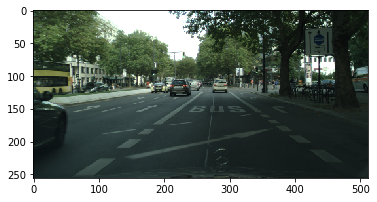

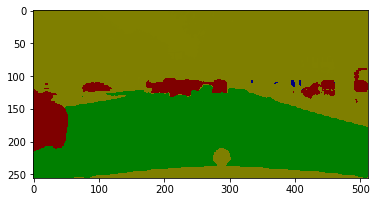

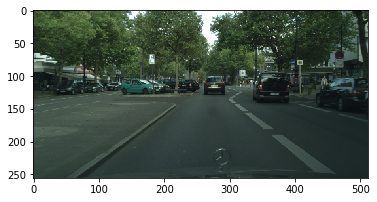

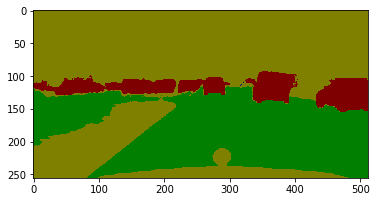

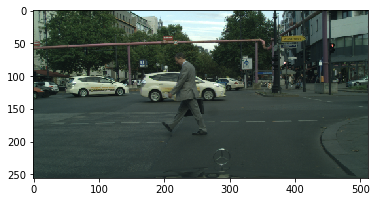

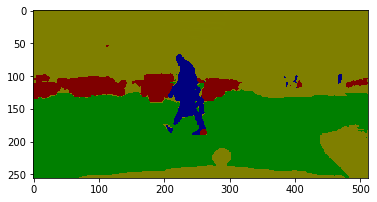

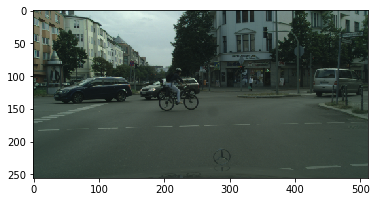

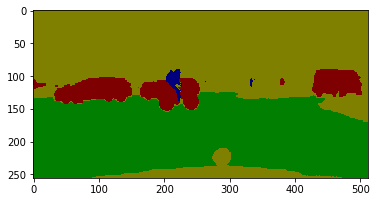

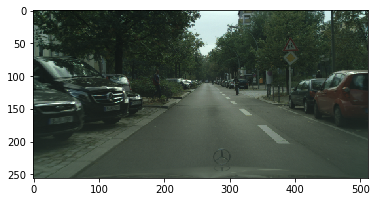

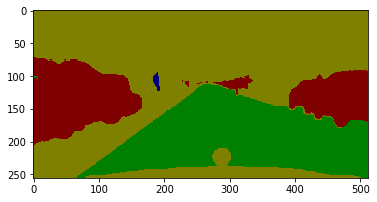

In [0]:
for i in range(len(testimg_list)):
  model.load_weights('unet_model_weight.h5')
  plot(testimg_list[i])

#### Plot the metrics - Loss, Dice Coefficient, IoU for train and validation to analyze their behaviour for each epoch

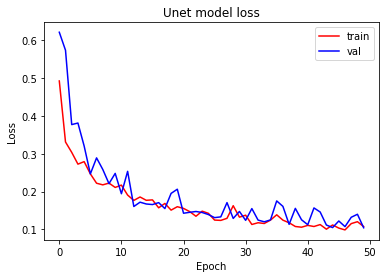

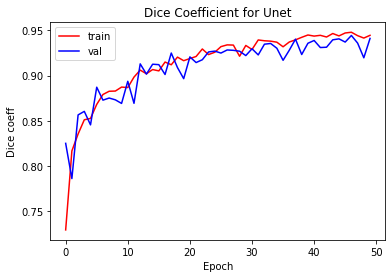

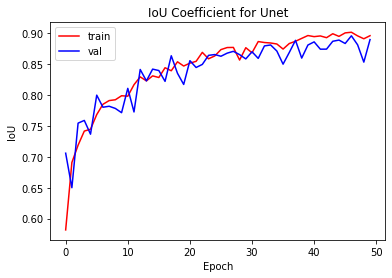

In [0]:
# Plot loss for train and validation for UNet model
plt.plot(history.history['loss'], color="r", label="train")
plt.plot(history.history['val_loss'], color="b", label="val")
plt.title('Unet model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

# Plot Dice coeficient Metric for train and validation for UNet model
plt.plot(history.history["dice"], color="r", label="train")
plt.plot(history.history["val_dice"], color="b", label="val")
plt.title("Dice Coefficient for Unet")
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

# Plot IoU Metric for train and validation for UNet model
plt.plot(history.history["iou"], color="r", label="train")
plt.plot(history.history["val_iou"], color="b", label="val")
plt.title("IoU Coefficient for Unet")
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

#### FCN 8 Computational Graph

In [0]:
fcn_image_input = Input(input_shape)

#FCN Section 1
fcn_conv_2D_layer_11 = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(fcn_image_input)
fcn_batch_norm_11 = BatchNormalization()(fcn_conv_2D_layer_11)
fcn_relu_11 = Activation('relu')(fcn_batch_norm_11)

fcn_conv_2D_layer_12 = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(fcn_relu_11)
fcn_batch_norm_12 = BatchNormalization()(fcn_conv_2D_layer_12)
fcn_relu_12 = Activation('relu')(fcn_batch_norm_12)

pool_1 = MaxPooling2D()(fcn_relu_12)

# FCN Section 2
fcn_conv_2D_layer_21 = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(pool_1)
fcn_batch_norm_21 = BatchNormalization()(fcn_conv_2D_layer_21)
fcn_relu_21 = Activation('relu')(fcn_batch_norm_21)

fcn_conv_2D_layer_22 = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(fcn_relu_21)
fcn_batch_norm_22 = BatchNormalization()(fcn_conv_2D_layer_22)
fcn_relu_22 = Activation('relu')(fcn_batch_norm_22)

pool_2 = MaxPooling2D()(fcn_relu_22)

# FCN Section 3
fcn_conv_2D_layer_31 = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(pool_2)
fcn_batch_norm_31 = BatchNormalization()(fcn_conv_2D_layer_31)
fcn_relu_31 = Activation('relu')(fcn_batch_norm_31)

fcn_conv_2D_layer_32 = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(fcn_relu_31)
fcn_batch_norm_32 = BatchNormalization()(fcn_conv_2D_layer_32)
fcn_relu_32 = Activation('relu')(fcn_batch_norm_32)

fcn_conv_2D_layer_33 = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(fcn_relu_32)
fcn_batch_norm_33 = BatchNormalization()(fcn_conv_2D_layer_33)
fcn_relu_33 = Activation('relu')(fcn_batch_norm_33)

pool_3 = MaxPooling2D()(fcn_relu_33)

# FCN Section 4
fcn_conv_2D_layer_41 = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(pool_3)
fcn_batch_norm_41 = BatchNormalization()(fcn_conv_2D_layer_41)
fcn_relu_41 = Activation('relu')(fcn_batch_norm_41)

fcn_conv_2D_layer_42 = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(fcn_relu_41)
fcn_batch_norm_42 = BatchNormalization()(fcn_conv_2D_layer_42)
fcn_relu_42 = Activation('relu')(fcn_batch_norm_42)

fcn_conv_2D_layer_43 = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(fcn_relu_42)
fcn_batch_norm_43 = BatchNormalization()(fcn_conv_2D_layer_43)
fcn_relu_43 = Activation('relu')(fcn_batch_norm_43)

pool_4 = MaxPooling2D()(fcn_relu_43)

# FCN Section 5
fcn_conv_2D_layer_51 = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(pool_4)
fcn_batch_norm_51 = BatchNormalization()(fcn_conv_2D_layer_51)
fcn_relu_51 = Activation('relu')(fcn_batch_norm_51)

fcn_conv_2D_layer_52 = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(fcn_relu_51)
fcn_batch_norm_52 = BatchNormalization()(fcn_conv_2D_layer_52)
fcn_relu_52 = Activation('relu')(fcn_batch_norm_52)

fcn_conv_2D_layer_53 = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(fcn_relu_52)
fcn_batch_norm_53 = BatchNormalization()(fcn_conv_2D_layer_53)
fcn_relu_53 = Activation('relu')(fcn_batch_norm_53)

pool_5 = MaxPooling2D()(fcn_relu_53)

# Load pretrained weights.
vgg16 = Model(fcn_image_input, pool_5)
vgg16.load_weights(vgg_path, by_name=True)

# Convolutinalized fully connected layer.
conv2d_layer_fcn = Conv2D(4096, (7, 7), activation='relu', padding='same')(pool_5)
batch_norm_layer_fcn = BatchNormalization()(conv2d_layer_fcn)
conv2d_layer_act = Activation('relu')(batch_norm_layer_fcn)
conv2d_layer_act = Conv2D(4096, (1, 1), activation='relu', padding='same')(conv2d_layer_act)
conv2d_batch_norm = BatchNormalization()(conv2d_layer_act)
conv2d_batch_act = Activation('relu')(conv2d_batch_norm)

# Layer for classification
cl_layer = Conv2D(num_classes, (1, 1), strides=(1, 1), activation='linear')(conv2d_batch_act)
cl_layer_bt_norm = BatchNormalization()(cl_layer)

pool_3 = Conv2D(num_classes, (1, 1), strides=(1, 1), activation='linear')(pool_3)
pool_3 = BatchNormalization()(pool_3)

pool_4 = Conv2D(num_classes, (1, 1), strides=(1, 1), activation='linear')(pool_4)
pool_4 = BatchNormalization()(pool_4)

#Upsampling with alternating Skip Connections
up_1 = Lambda(lambda x: tf.image.resize_images(x, (x.shape[1] * 2, x.shape[2] * 2)))(cl_layer_bt_norm)
skip_1 = Add()([up_1, pool_4])

skip_1_relu = Activation('relu')(skip_1)

up_2 = Lambda(lambda x: tf.image.resize_images(x, (x.shape[1] * 2, x.shape[2] * 2)))(skip_1_relu)
skip_2 = Add()([up_2, pool_3])
skip_2_relu = Activation('relu')(skip_2)

up_3 = Lambda(lambda x: tf.image.resize_images(x, (x.shape[1] * 8, x.shape[2] * 8)))(skip_2_relu)
out_up = Activation('softmax')(up_3)

model = Model(fcn_image_input, out_up)
model.compile(optimizer=Adam(lr=learn_rate, decay=learn_rate_decay), loss='categorical_crossentropy', metrics=['acc', dice, iou])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 512, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 256, 512, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 256, 512, 64) 0           batch_normalization_80[0][0]     
____________________________________________________________________________________________

#### Training the FCN 8 Model

In [0]:
train_batch = 4 
val_batch = 1 

# Checkpoint Definition
checkpoint = ModelCheckpoint(filepath='fcn_model_weight.h5',
                             monitor='val_acc',
                             save_best_only=True,
                             save_weights_only=True)

history = model.fit_generator(generate_data("/content/drive/My Drive/Deep Learning Project/Data/cityscapes.h5", train_batch, 'train'),
                              steps_per_epoch=500 // train_batch,
                              validation_data=generate_data("/content/drive/My Drive/Deep Learning Project/Data/cityscapes.h5", val_batch, 'val'),
                              validation_steps=50 // val_batch,
                              callbacks=[checkpoint],
                              epochs=50,
                              verbose=1)

Epoch 1/50
125/125 [==============================] - 51s 408ms/step - loss: 0.5863 - acc: 0.8324 - dice: 0.6513 - iou: 0.4860 - val_loss: 0.4696 - val_acc: 0.8801 - val_dice: 0.7052 - val_iou: 0.5477
Epoch 2/50
125/125 [==============================] - 41s 325ms/step - loss: 0.4462 - acc: 0.8880 - dice: 0.7193 - iou: 0.5623 - val_loss: 0.4371 - val_acc: 0.8979 - val_dice: 0.7237 - val_iou: 0.5696
Epoch 3/50
125/125 [==============================] - 40s 323ms/step - loss: 0.4054 - acc: 0.9027 - dice: 0.7418 - iou: 0.5904 - val_loss: 0.4320 - val_acc: 0.8920 - val_dice: 0.7244 - val_iou: 0.5705
Epoch 4/50
125/125 [==============================] - 40s 323ms/step - loss: 0.3570 - acc: 0.9169 - dice: 0.7671 - iou: 0.6235 - val_loss: 0.3475 - val_acc: 0.9276 - val_dice: 0.7606 - val_iou: 0.6162
Epoch 5/50
125/125 [==============================] - 40s 322ms/step - loss: 0.3393 - acc: 0.9207 - dice: 0.7793 - iou: 0.6395 - val_loss: 0.3815 - val_acc: 0.9107 - val_dice: 0.7492 - val_iou: 0.

#### Predicting the test image from trained FCN-8 Model

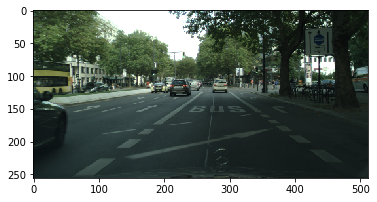

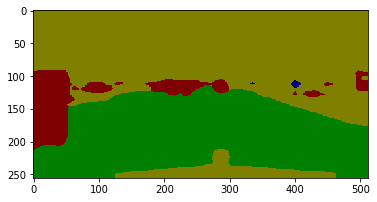

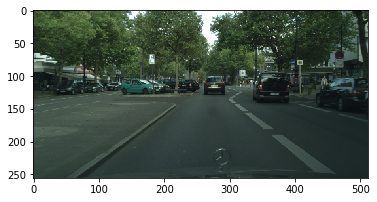

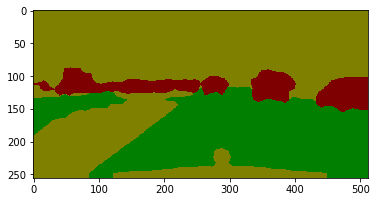

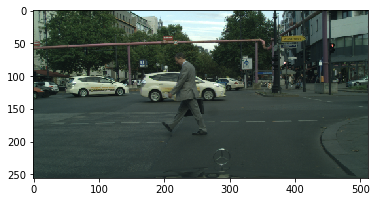

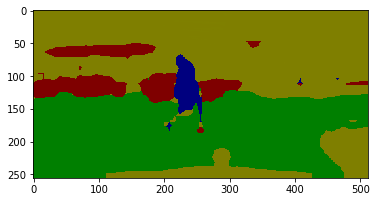

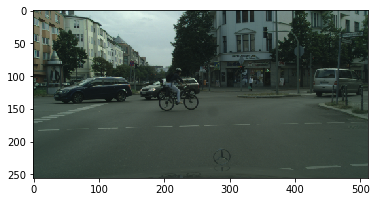

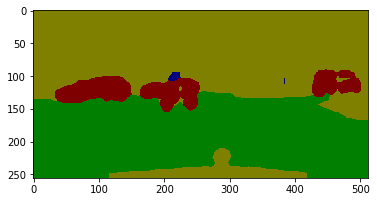

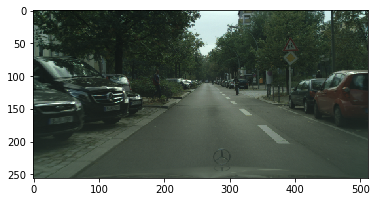

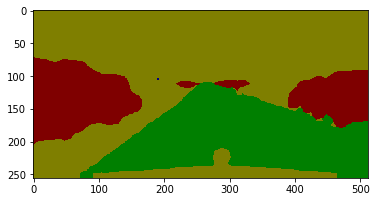

In [0]:
testimg_list = test_imgs[:5]
for i in range(len(testimg_list)):
  model.load_weights('fcn_model_weight.h5')
  plot(testimg_list[i])

#### Plot the metrics - Loss, Dice Coefficient, IoU for train and validation to analyze their behaviour for each epoch

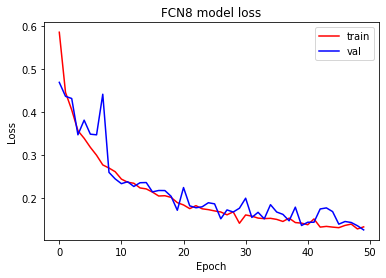

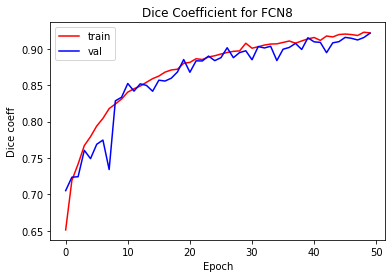

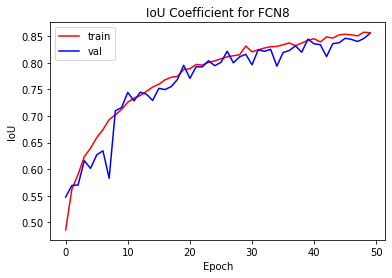

In [0]:
# Plot loss for train and validation for FCN 8 model
plt.plot(history.history['loss'], color="r", label="train")
plt.plot(history.history['val_loss'], color="b", label="val")
plt.title('FCN8 model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

# Plot Dice coeficient Metric for train and validation for FCN 8 model
plt.plot(history.history["dice"], color="r", label="train")
plt.plot(history.history["val_dice"], color="b", label="val")
plt.title("Dice Coefficient for FCN8")
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

# Plot IoU Metric for train and validation for FCN 8 model
plt.plot(history.history["iou"], color="r", label="train")
plt.plot(history.history["val_iou"], color="b", label="val")
plt.title("IoU Coefficient for FCN8")
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()